In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

fullset = pd.read_csv('hatespeech-bruehl-momenzada.csv')

In [21]:
fullset['class'].value_counts()

offensive    19712
hate         17033
nothing       4163
Name: class, dtype: int64

## Cleaning

Unfortunately, this dataset has no emojis.

We do not remove stopwords (such as i, and, myself, etc. which are included in the ntlk stopwords list), since this can distort the context of a text

In [22]:
def clean_series(corpus:pd.Series) -> pd.Series:
    #get rid of further symbols 
    corpus = corpus.replace({'[»„‘’“”…]': ' '}, regex=True)
    
    #get rid of digits
    corpus = corpus.replace({'\w*\d\w*': 'Nummer'}, regex=True)

    # get rid of urls
    corpus = corpus.replace({r"https?://\S+|www\.\S+": ' '}, regex=True)

    #get not identified unicode
    corpus = corpus.replace('[\u0080-\uffff]w{1-3}', " ", regex=True)
    
    #delete /t and /n
    corpus = corpus.replace('/t', " ", regex=True)
    corpus = corpus.replace('/n', " ", regex=True)

    # replaces all stringw which are unicodes (\u2009 \a0x) and also removes bashes
    corpus = corpus.replace({r"[^\x00-\x7F\w{1,3}]+": ' '}, regex=True)
    
    # remove @usernames
    corpus = corpus.replace({r"(#[\d\w\.]+)": ' '}, regex=True)

    return corpus

fullset['text'] = clean_series(fullset['text'])

## Define Labels as numbers

In [23]:
#define labels
lb_make = LabelEncoder()
fullset["label_id"] = lb_make.fit_transform(fullset["class"])

In [24]:
# The maximum number of most frequent words to be used.
MAX_NB_WORDS = 59000
# Max number of words in each row
MAX_SEQUENCE_LENGTH = 150
#feature vector length
HIDDEN_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(fullset['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 59667 unique tokens.


In [25]:
# import pickle as pkl
# with open('tokenizer.pkl','wb') as f:
#     pkl.dump(tokenizer, f)

In [26]:
# define X and Y
X = tokenizer.texts_to_sequences(fullset['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(fullset['class']).values
print('Shape of label tensor:', Y.shape)

# a really messy way to save labels
onehot_labels = pd.get_dummies(fullset['class'])
labels = onehot_labels.drop_duplicates(subset=onehot_labels.columns).reset_index(drop=True)

Shape of data tensor: (40908, 150)
Shape of label tensor: (40908, 3)


In [27]:
# with open('offensive_hate.pkl','wb') as f:
#      pkl.dump(X, f)

## Define train and test

In [28]:
#split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

## Define model and saving path

In [8]:
#save model
from __future__ import absolute_import, division, print_function
import os

checkpoint_path = "model_pretrain/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                  save_weights_only=True,
                                                 verbose=1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,SpatialDropout1D, LSTM,Conv1D,MaxPooling1D
from tensorflow.keras import layers

def hate_offensive_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, HIDDEN_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model 

## Train model

In [11]:
model = hate_offensive_model()

epochs = 5
batch_size = 128
model.fit(X_train, Y_train,epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[cp_callback])

Epoch 1/5
216/216 [==============================] - 187s 856ms/step - loss: 0.4653 - accuracy: 0.8167 - val_loss: 0.3029 - val_accuracy: 0.8886

Epoch 00001: saving model to model_pretrain\cp.ckpt
Epoch 2/5
216/216 [==============================] - 208s 961ms/step - loss: 0.2019 - accuracy: 0.9300 - val_loss: 0.2547 - val_accuracy: 0.9058

Epoch 00002: saving model to model_pretrain\cp.ckpt
Epoch 3/5
216/216 [==============================] - 203s 941ms/step - loss: 0.1210 - accuracy: 0.9611 - val_loss: 0.2927 - val_accuracy: 0.8993

Epoch 00003: saving model to model_pretrain\cp.ckpt
Epoch 4/5
216/216 [==============================] - 230s 1s/step - loss: 0.0753 - accuracy: 0.9770 - val_loss: 0.3283 - val_accuracy: 0.8967

Epoch 00004: saving model to model_pretrain\cp.ckpt
Epoch 5/5
216/216 [==============================] - 308s 1s/step - loss: 0.0517 - accuracy: 0.9841 - val_loss: 0.3671 - val_accuracy: 0.8915

Epoch 00005: saving model to model_pretrain\cp.ckpt


### Evaluation

In [18]:
MODEL_PATH = "./model_pretrain/cp.ckpt"

model = hate_offensive_model()
model.load_weights(MODEL_PATH)

In [29]:
accr = model.evaluate(X_test,Y_test)
print('\n Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

320/320 [==============================] - 13s 37ms/step - loss: 0.3915 - accuracy: 0.8903

 Test set
  Loss: 0.392
  Accuracy: 0.890


In [71]:
labels_dic = {
    0:'hate',
    1: 'nothing',
    2: 'offensinve'
}

Y_index_labels = [list(i).index(1) for i in Y_test]
Y_test_str = [labels_dic[i] for i in index_labels]

y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
Y_preds_str = [labels_dic[i] for i in list(y_classes)]

#### Please Note! Our Dataset is unbalanced and has less data for "neither" label. Considering that, the confusion matrix shows decent results.

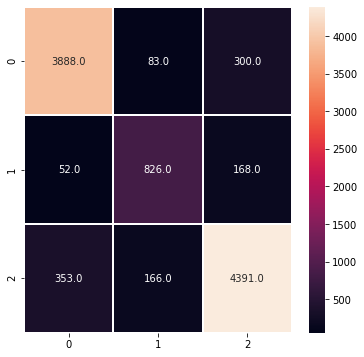

In [72]:
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix(y_pred=Y_preds_str,y_true=Y_test_str)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()

### Evaluation for each Dataset (if you are interested)

In [73]:
_, testset = train_test_split(fullset, test_size = 0.25, random_state = 42)

In [78]:
test_david = testset[testset.source == 'davidson']
test_jing_gab = testset[testset.source == 'jing_gab']
test_jing_reddit = testset[testset.source == 'jing_reddit']

In [194]:
def one_hot_encoding(label_id):
    label_id = list(label_id)
    df = pd.DataFrame(columns=labels.columns)
    for i in range(0,len(label_id)):
        df.loc[i] = 0
        label = label_id[i]
        df[label][i] = 1
        
    one_hot_np = df.to_numpy().astype(np.float32)

    return one_hot_np


def predict_text(texts, labels):
    labels = one_hot_encoding(labels)
    labels = tf.convert_to_tensor(labels)
    texts = clean_series(texts)
    tokens_text = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(tokens_text, maxlen=MAX_SEQUENCE_LENGTH)
    accr = model.evaluate(padded,labels)
    
    return labels

In [208]:
jing_gab_accr = predict_text(test_jing_gab['text'], test_jing_gab['class'])

85/85 [==============================] - 3s 39ms/step - loss: 0.0423 - accuracy: 0.9860


In [209]:
jing_reddit_accr = predict_text(test_jing_reddit['text'], test_jing_reddit['class'])

28/28 [==============================] - 1s 40ms/step - loss: 0.0888 - accuracy: 0.9713


In [210]:
david_accr = predict_text(test_david['text'], test_david['class'])

193/193 [==============================] - 8s 39ms/step - loss: 0.4932 - accuracy: 0.8629
